<h3><center>Corporate Burnout Regression</center></h3>   

    
<center>Sam Loyd</center>
<center>June 2021</center> 

In [33]:
# Required Modules
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import *
from imblearn.combine import SMOTETomek
from collections import Counter
from pycaret.regression import *
from sklearn import metrics
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

## Data Analysis - EDA

In [2]:
# Pull in data for stroke data 
train_df = pd.read_csv("data\\train.csv")
# test_df = pd.read_csv("data\\test.csv")

In [3]:
# Setup frame
# frames = [train_df, test_df]

In [4]:
# Join them
# burnout_df = pd.concat(frames)

# Test data has no target variables
burnout_df = train_df

In [5]:
# First look
burnout_df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [6]:
# Apply profie and create html report
# Commented out for performance
# prof = ProfileReport(burnout_df,title="Pandas Profiling Report - Burnout Data", explorative=True)
# prof.to_file(output_file='burnout-pandas-profile-report.html')

# Please see stroke-pandas-profile-report.html for a full analysis 

### [Pandas report](https://sdloyd.github.io/Stroke/pandasprofile/stroke-pandas-profile-report.html)

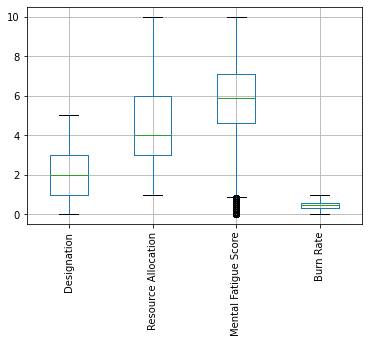

In [7]:
# Pandas-profiling is lacking in outlier analysis visuals so those are included here.
# Only mental fatigue score shows outliers

# Box and whisker plots for outlier analysis.
boxplot = burnout_df.boxplot(column=['Designation','Resource Allocation','Mental Fatigue Score','Burn Rate'],rot=90)


## Data Wrangling  
Impute missing values found in the EDA process using pandas-profile report and remove rows missing target variable.

In [8]:
# Take a look - saw no significant reason to standardize or normalize based on the max values
burnout_df.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,22750.000000,21369.000000,20633.000000,21626.000000
mean,2.178725,4.481398,5.728188,0.452005
std,1.135145,2.047211,1.920839,0.198226
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.310000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


In [9]:
# Count nulls
burnout_df.isnull().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

In [10]:
# Since burnrate is the target removing any rows missing burnrate
burnout_df.dropna(subset=['Burn Rate'], inplace=True)

In [11]:
# Separate target variable before imputation to avoid future data concerns
knn_df = burnout_df.drop(['Burn Rate'], axis=1)

In [12]:
# Impute with K nearest
impute = KNNImputer(n_neighbors = 6, weights = 'uniform')
knn_df['Resource Allocation'] = impute.fit_transform(knn_df[['Resource Allocation']])
knn_df['Mental Fatigue Score'] = impute.fit_transform(knn_df[['Mental Fatigue Score']])

In [13]:
# New Frame
clean_burnout_df = knn_df

In [14]:
# Add target back
clean_burnout_df['Burn Rate'] = burnout_df['Burn Rate']

In [15]:
# First look
clean_burnout_df

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.000000,3.800000,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.000000,5.000000,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,4.483831,5.800000,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.000000,2.600000,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.000000,6.900000,0.52
...,...,...,...,...,...,...,...,...,...
22745,fffe31003500370039003100,2008-12-30,Female,Service,No,1.0,3.000000,5.729851,0.41
22746,fffe33003000350031003800,2008-01-19,Female,Product,Yes,3.0,6.000000,6.700000,0.59
22747,fffe390032003000,2008-11-05,Male,Service,Yes,3.0,7.000000,5.729851,0.72
22748,fffe33003300320036003900,2008-01-10,Female,Service,No,2.0,5.000000,5.900000,0.52


In [16]:
# Count nulls
clean_burnout_df.isnull().sum()

Employee ID             0
Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
Burn Rate               0
dtype: int64

In [17]:
# Binary values
# 1 unknown, but I made it female since it was the most common
clean_burnout_df['Gender'] = np.where(clean_burnout_df['Gender']=='Male', 1, 0)
clean_burnout_df['Company Type'] = np.where(clean_burnout_df['Company Type']=='Product', 1, 0)
clean_burnout_df['WFH Setup Available'] = np.where(clean_burnout_df['WFH Setup Available']=='True', 1, 0)

In [18]:
# Any impact on stats - looks acceptable 
clean_burnout_df.describe()

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,21626.000000,21626.000000,21626.0,21626.000000,21626.000000,21626.000000,21626.000000
mean,0.475215,0.346897,0.0,2.178766,4.483831,5.729851,0.452005
std,0.499397,0.475994,0.0,1.135428,1.986727,1.832370,0.198226
min,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.0,1.000000,3.000000,4.700000,0.310000
50%,0.000000,0.000000,0.0,2.000000,4.483831,5.729851,0.450000
75%,1.000000,1.000000,0.0,3.000000,6.000000,6.900000,0.590000
max,1.000000,1.000000,0.0,5.000000,10.000000,10.000000,1.000000


In [19]:
clean_burnout_df

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,0,0,0,2.0,3.000000,3.800000,0.16
1,fffe3700360033003500,2008-11-30,1,0,0,1.0,2.000000,5.000000,0.36
2,fffe31003300320037003900,2008-03-10,0,1,0,2.0,4.483831,5.800000,0.49
3,fffe32003400380032003900,2008-11-03,1,0,0,1.0,1.000000,2.600000,0.20
4,fffe31003900340031003600,2008-07-24,0,0,0,3.0,7.000000,6.900000,0.52
...,...,...,...,...,...,...,...,...,...
22745,fffe31003500370039003100,2008-12-30,0,0,0,1.0,3.000000,5.729851,0.41
22746,fffe33003000350031003800,2008-01-19,0,1,0,3.0,6.000000,6.700000,0.59
22747,fffe390032003000,2008-11-05,1,0,0,3.0,7.000000,5.729851,0.72
22748,fffe33003300320036003900,2008-01-10,0,0,0,2.0,5.000000,5.900000,0.52


In [20]:
# No need to pass to model, just an ID
model_burnout_df = clean_burnout_df.drop(['Employee ID'], axis=1)

In [21]:
# Split the validation and train data - Pycaret will split out the test
# Create X from the features
X = model_burnout_df.drop(columns=['Burn Rate'])

# Create y from output
y = model_burnout_df[['Burn Rate']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.40, random_state=1)

In [22]:
# PyCaret requires them in one dataframe
X_train_caret_reg = X_train.copy()
X_train_caret_reg['Burn Rate'] = y_train['Burn Rate']
X_train_caret_reg

,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
11215,2008-04-10,0,0,0,3.0,5.0,6.200000,0.59
4585,2008-09-04,0,0,0,4.0,7.0,8.600000,0.88
21893,2008-02-16,0,0,0,3.0,6.0,6.800000,0.55
21891,2008-07-27,0,0,0,3.0,5.0,4.600000,0.28
13160,2008-03-30,0,0,0,1.0,1.0,5.729851,0.26
...,...,...,...,...,...,...,...,...
11507,2008-03-03,0,0,0,2.0,6.0,7.200000,0.58
18190,2008-06-22,0,0,0,3.0,4.0,4.800000,0.39
5434,2008-10-16,0,0,0,3.0,5.0,3.600000,0.24
12790,2008-08-01,1,1,0,0.0,1.0,3.500000,0.18


In [23]:
# Prepare model
exp_clf_reg = setup(X_train_caret_reg, target='Burn Rate', silent=True)

,Description,Value
0,session_id,944
1,Target,Burn Rate
2,Original Data,"(12975, 8)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(9082, 27)"


In [24]:
# Compare the model
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0479,0.0037,0.0608,0.9057,0.0419,0.1429,0.3190
catboost,CatBoost Regressor,0.0480,0.0037,0.0611,0.9050,0.0421,0.1429,1.7480
gbr,Gradient Boosting Regressor,0.0489,0.0039,0.0623,0.9012,0.0430,0.1469,0.3420
xgboost,Extreme Gradient Boosting,0.0498,0.0041,0.0636,0.8968,0.0437,0.1480,1.1610
rf,Random Forest Regressor,0.0504,0.0042,0.0650,0.8924,0.0448,0.1485,1.1600
et,Extra Trees Regressor,0.0527,0.0048,0.0695,0.8770,0.0480,0.1557,1.5920
lr,Linear Regression,0.0544,0.0051,0.0717,0.8691,0.0498,0.1725,0.6220
ridge,Ridge Regression,0.0544,0.0051,0.0717,0.8691,0.0498,0.1725,0.0150
lar,Least Angle Regression,0.0544,0.0051,0.0717,0.8691,0.0498,0.1725,0.0170
br,Bayesian Ridge,0.0544,0.0051,0.0717,0.8691,0.0498,0.1725,0.0210


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=944, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [25]:
# Model selected - lightgbm
model_pick = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0473,0.0036,0.0603,0.9156,0.0408,0.1376
1,0.0475,0.0037,0.0605,0.9044,0.0419,0.1499
2,0.0472,0.0035,0.0588,0.9103,0.0404,0.1297
3,0.0499,0.0041,0.0639,0.8976,0.0451,0.1519
4,0.0495,0.0040,0.0634,0.8973,0.0437,0.1553
5,0.0472,0.0035,0.0594,0.9159,0.0407,0.1298
6,0.0497,0.0038,0.0620,0.8971,0.0428,0.1482
7,0.0462,0.0036,0.0602,0.9081,0.0410,0.1338
8,0.0479,0.0036,0.0602,0.9056,0.0412,0.1534
9,0.0462,0.0035,0.0595,0.9053,0.0414,0.1391


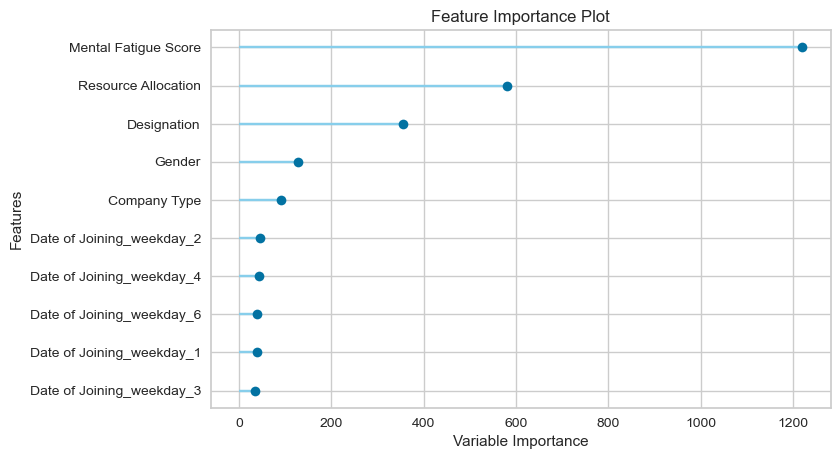

In [26]:
# Lets look at them - Note pycaret took care of the encoding on date 
plot_model(model_pick, plot='feature')

In [27]:
# Tuning
tuned_model_pick = tune_model(model_pick)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0497,0.0040,0.0636,0.9060,0.0432,0.1485
1,0.0482,0.0039,0.0622,0.8989,0.0433,0.1633
2,0.0487,0.0038,0.0613,0.9025,0.0423,0.1375
3,0.0501,0.0042,0.0651,0.8936,0.0460,0.1567
4,0.0504,0.0041,0.0644,0.8941,0.0445,0.1626
5,0.0490,0.0038,0.0619,0.9086,0.0426,0.1349
6,0.0501,0.0040,0.0631,0.8935,0.0436,0.1516
7,0.0478,0.0039,0.0623,0.9015,0.0426,0.1456
8,0.0496,0.0039,0.0622,0.8992,0.0428,0.1678
9,0.0475,0.0037,0.0612,0.8999,0.0428,0.1452


In [30]:
# Finalize the model
final_model = finalize_model(tuned_model_pick)

In [31]:
# predict validation data
val_predictions = predict_model(final_model, data=X_val)
val_predictions.Label

10357    0.200322
9443     0.522811
20516    0.427496
8902     0.352677
12396    0.257912
           ...   
22657    0.479743
14423    0.369562
5167     0.821598
19732    0.577477
19714    0.396552
Name: Label, Length: 8651, dtype: float64

In [34]:
mae = metrics.mean_absolute_error(y_val, val_predictions.Label)
mse = metrics.mean_squared_error(y_val, val_predictions.Label)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = r2_score(y_val, val_predictions.Label)

print("Results:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results:
MAE: 0.04841930103200419
MSE: 0.0038231816415093037
RMSE: 0.06183188207963028
R-Squared: 0.9019347977263243


In [35]:
# Save the model as a pickle file
filename = 'pickle/stroke_model.pickle'
pickle.dump(final_model, open(filename, 'wb'))

In [36]:
save_model(final_model, 'model/stroke_model')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='Burn Rate',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strate...
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=0.5,
                                importance_type='split', learning_rate=0.16,
                                max_depth=-1, min_child_samples=40,
                  